Training with **Sentinel-1 GRD** data (IW mode, VV+VH polarization). This notebook is a replica of the notebook for the training with Sentinel-2 data, but with minor adjustments to adapt it to Sentinel-1 images.

# 0. Setup

## 0.1. Libraries

In [ ]:
# Utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import torch
from torch import nn, utils
from torchmetrics import classification

# Custom library
from library import nn_model, utilities, visualizations, preprocessing

# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(f'Using device: {device}')

# Utilities
seed = 42
utilities.set_seed(seed)

Using device: cuda
Seed set to 42 for NumPy, Torch and Random for reproducibility.


## 0.2. Setting the path to the training data

We set the path to the tiles that have been created in the preprocessing notebook, `3_preprocessing.ipynb`.

In [2]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset')  # Path to the original labelled dataset
tile_dir = os.path.join(base_input_dir, 'tiled_labelled_dataset')  # Path to the tiled dataset
sentinel_type = 1  # Sentinel-1 data

## 0.3. Notebook description

We train a multi-class segmentation model that assesses wildfire severity using satellite images **from Sentinel-2 L2A** (the "natural-looking" images). Additional steps applied during training:
- Randomly shuffle the tiles (done at the training stage).
- Apply data augmentation techniques to improve the robustness of the model. The authors implement the following transformations (we will do similar but different ones, this is just as reference): "*We applied the following transformations: rotation (up to 50° on both sides), shear (up to 20°), horizontal flip, and vertical flip, all of them with a probability of 50%.*"
- If computationally feasible, we will do cross-fold validation. Otherwise, we will just divide the data statically into training, validation and test. The authors use "*a 7-fold cross-validation approach [...]: 5 folds were used as a training set, 1 fold as a validation set, and 1 fold as a test set.*"
- Adjust the training hyperparameters: "*16GB. The training was performed using 50 epochs, the Adam optimizer with a learning rate of 0.0001 with no weight decay. The Dice loss was used for training. [...] We implemented an early stopping mechanism with patience of 5 epochs and tolerance of 0.01 on validation loss. The final evaluation is performed on the test set.*"

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

We are going to use the U-Net architecture:

![U-Net model](unet_diagram.jpg)

# 1. Preparing the data

## 1.1. Getting the image and masks paths

In [3]:
# Get all of the folders within the tiles directory
fire_folders = sorted([f for f in os.listdir(tile_dir) if os.path.isdir(os.path.join(tile_dir, f))])
# Print the first 5 folders
print("First 5 fire folders:")
print(fire_folders[:5])
# Print the total number of fire folders
print("Total number of fire folders:", len(fire_folders))

# Get the paths for the images and the labels
image_paths = []
label_paths = []
for fire_folder in fire_folders:
    print(f"Fire folder: {fire_folder}")
    images_path = os.path.join(tile_dir, fire_folder, 'images')
    labels_path = os.path.join(tile_dir, fire_folder, 'masks')
    if os.path.exists(images_path):
        image_paths.append(sorted([os.path.join(images_path, img) for img in os.listdir(images_path) if img.startswith(f'sentinel{sentinel_type}') and img.endswith('.tiff')]))
    else:
        print(f"Images path does not exist: {images_path}")
    if os.path.exists(labels_path):
        label_paths.append(sorted([os.path.join(labels_path, lbl) for lbl in os.listdir(labels_path) if lbl.endswith('.tiff')]))
    else:
        print(f"Labels path does not exist: {labels_path}")
# Print the first 5 image paths
print(f"First 5 image and label paths of the fire folder: {fire_folders[0]}")
print(image_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of images for a specific fire folder
print(label_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of labels for a specific fire folder

# Print the total number of lists in image_paths and label_paths (should be equal to the number of fire folders)
print("Total number of fire folders in image_paths:", len(image_paths))
print("Total number of fire folders in label_paths:", len(label_paths))

First 5 fire folders:
['EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector', 'EMSR207_02LOUSA_02GRADING_MAP_v2_vector', 'EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector', 'EMSR207_04AVELAR_02GRADING_MAP_v2_vector', 'EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector']
Total number of fire folders: 73
Fire folder: EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
Fire folder: EMSR207_02LOUSA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_04AVELAR_02GRADING_MAP_v2_vector
Fire folder: EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_06MADEIRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_07ALVAIAZERE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2_vector
Fire folder: EMSR207_10ORVALHO_02GRADING_MAP_v2_vector
Fire folder: EMSR209_01MOGUER_02GRADING_MAP_v2_vector
Fire folder: EMSR209_02MAZAGON_02GRADING_MAP_v2_vector
Fire folder: EMSR209_03LOSCABEZUDOS_02GRADING_MAP_v1_vecto

## 1.2. Loading the image and masks into tensors

We load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$, where:
- $n$: number of images (tiles)/masks.
- $d$: number of channels for the images/masks.
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

We normalize each channel to $N[0,1]$ and set the data type as `torch.float32` (set to `torch.float16` for greater memory efficiency). Why we normalize image channels:

1. **Gradient stability**: Different channels may have vastly different value ranges, leading to unstable gradients
2. **Training speed**: Normalized inputs help the optimizer converge faster
3. **Weight initialization**: Most weight initialization schemes assume normalized inputs
4. **Activation functions**: Work optimally with inputs in specific ranges

In [4]:
# Flatten the lists of image and label paths
images_flat = [item for sublist in image_paths for item in sublist]
labels_flat = [item for sublist in label_paths for item in sublist]

# Remember that there are no S1 images for the event "EMSR368_AOI01_GRA_PRODUCT_r1_RTP01_v3_vector"
# (shown in the preprocessing notebook), so we will remove them from the labels list
labels_flat = [label for label in labels_flat if 'EMSR368_AOI01_GRA_PRODUCT_r1_RTP01_v3_vector' not in label]

# Read images and labels and stack them into a single tensor (reduce precision to float16 for greater efficiency)
images = torch.stack([utilities.read_tiff_to_torch(file_path = image, dtype=torch.float32, normalize=True, normalization_method='per_channel') for image in images_flat])
labels_raw = torch.stack([utilities.read_tiff_to_torch(file_path = label, dtype = torch.float32, normalize=True, normalization_method='255') for label in labels_flat])  # Masks are encoded in 0-255 range according to the paper

Now, let's check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

In [5]:
print('Size of the image tensor:', images.size())
print('Size of the label tensor:', labels_raw.size())

# Check if the number of images and labels are equal
if images.size(0) != labels_raw.size(0):
    raise ValueError('Number of images and labels do not match!')

Size of the image tensor: torch.Size([3176, 4, 256, 256])
Size of the label tensor: torch.Size([3176, 1, 256, 256])


i.e., in this case:

- $n$: we have 3,176 images and masks (3,374 images before removing those without coverage in the EDA notebook; and there were 54 images missing images from Sentinel-1 for a wildfire in the dataset).
- $d$: number of channels for the images/masks. The images have 4 dimensions (see https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html#available-bands-and-data).
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

## 1.3. Checking the alignment: displaying several image-label pairs

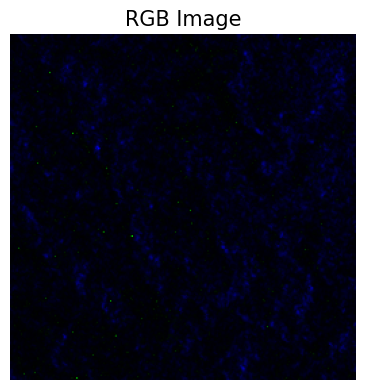

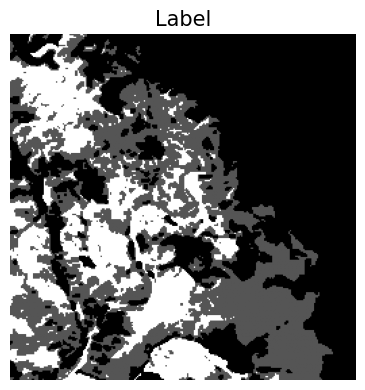

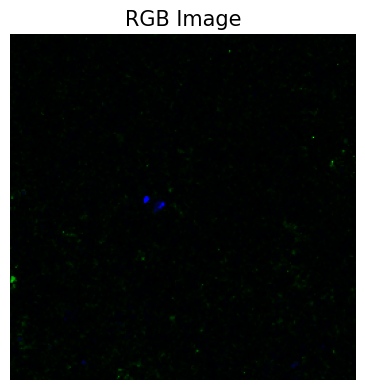

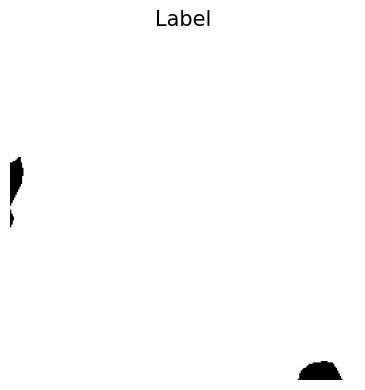

In [6]:
# Displays random images, labels and images
for i in torch.randint(0, len(images), (2,)):
  visualizations.display_image(image = images[i], title = 'RGB Image', rgb_bands=(3,2,1))  # RGB bands in Sentinel-2 are 3 (B04), 2 (B03), and 1 (B02)
  visualizations.display_image(image = labels_raw[i], title = 'Label')

Note that, in this case, **the brighter the label in the mask, the higher the severity of the fire (white if maximum severity)**. Areas affected by fires of lower severity are darker. 

## 1.4. Mapping the classes to integers 

In [7]:
# Apply the mapping
labels = utilities.map_labels_to_classes_approximate(labels_raw)

del labels_raw  # Free up memory

In [8]:
# Print the unique values in the labels tensor to verify the mapping
print("Unique values in the labels tensor after mapping:", torch.unique(labels))

Unique values in the labels tensor after mapping: tensor([0, 1, 2, 3, 4])


## 1.5. Formatting the data as a `TensorDataset`

Useful documentation: [`torch.utils.data`](https://pytorch.org/docs/stable/data.html)

In [9]:
# Format the data as a TensorDataset
dataset = utils.data.TensorDataset(images, labels)  # Create a TensorDataset from the image and label tensors
print(len(dataset))

3176


## 1.6. Splitting data into train, validation and test

We split into 70% training data, 15% validation and 15% test.

In [10]:
# Split the dataset into training, validation and test sets
train_dataset, val_dataset, test_dataset = utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

# Set batch size
batch_size = 64

# Set number of physical CPU cores (as int) to use for data loading
num_workers = os.cpu_count() // 2 if os.cpu_count() is not None else 0

# Create DataLoaders for each dataset
train_loader = utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle the training data to prevent learning order bias, overfitting and improve generalization
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

val_loader = utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep validation data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

test_loader = utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep test data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

# 2. Training and validation

## 2.1. Neural Network Architecture

![U-Net model](unet_diagram.jpg)

The basic structure of this network is the following:

1. **Input**: a tensor of shape $(N, D, H, W)$.
2. **Encode** down through five levels, doubling channels each time and halving spatial dimensions.
3. **Bottleneck**: deepest features at 128 channels.
4. **Decode** back up, halving channels and doubling spatial dimensions, while concatenating corresponding encoder features to preserve fine details.
5. **Output**: apply a 1×1 convolution → Sigmoid to produce a mask of shape $(N, 1, H, W)$ with values in (0,1).

All of the classes below initialize the parameters at each layer with `__init__` and then implement a `forward` method that defines the forward pass of the neural network, which "takes the input data and passes it through the layers of the network to produce the output. This method is executed whenever the model is called to make a prediction or to compute the loss during training" ([reference](https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907)).

### The double convolution

The two convolutional layers are included everywhere in the network, from the encoding to the decoding. For more information, check `DoubleConv` in the library `library`.

Useful sources:
- [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) - convolutional layer
- [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) - normalization layer
- [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) - non-linear activation function

### The encoder module (`Down`)

The class below represents one encoding step. For more information, check `Down` in the library `library`.

Useful sources:
- [`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) - pooling layer

### The decoder module (`Up`)

This class represents one decoding step. It performs upsampling and concatenation with skip connection. For more information, check `Up` in the library `library`.

This class:

1. Upsamples via either bilinear interpolation or a learnable transposed convolution. See [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample)
2. Pads if the resulting feature-map is off by 1 pixel in height/width. See [`nn.functional.pad`](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad)
3. Concatenates with the corresponding encoder feature-map along the channel dimension (the “skip connection”). See [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)
4. Uses `DoubleConv` to fuse and refine these combined features.

### Final 1 $\times$ 1 convolution

This convolution reduces the channels from whatever the last decoder output is (in the diagram, 8) down to the desired number of classes (1 for binary mask, as in this case - 0 for no building and 1 for building). For more information, check `OutConv` in the library `library`.

### Putting all together in `UNet`

This class uses the constructions made above, and replicates the structure of the neural network in the diagram. For more information, check `UNet` in the library `library`.

Note that the output layer returns the logits, not probabilities, for compatibility with the loss function.

## 2.2. Training setup

### Model initialization

In [11]:
# Set the parameters for the U-Net model
n_channels = images.size()[1]  # Number of input channels (4 for Sentinel-1 in this case: VV, VH, VV/VH ratio, and VV/VH difference)
n_classes = 5  # Number of output channels (5 classes: 0: not burned, 1-4: burned area with different severity levels, from lower to higher severity)
base_filters = 8  # Number of filters in the first layer (check diagram)
dropout_p = 0.1  # Dropout probability for regularization
bilinear = False  # Use bilinear interpolation for upsampling (True) or transposed convolution (False)

# Initialize the model
model = nn_model.UNet(
    n_channels=n_channels,
    n_classes=n_classes, 
    base_filters=base_filters,
    dropout_p=dropout_p,
    bilinear=bilinear
)
model = model.to(device)  # Move the model to the specified device (GPU or CPU)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.1, inplace=False)
    )
  )
  (down1): Down(
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

### Loss function (addresses class imbalance)

Simple weights where we weight more the less common classes, and underweight the most common ones.

In [12]:
# Calculate class frequencies and weights
def calculate_class_weights(labels_tensor, n_classes=5):
    """
    Calculate class weights for handling class imbalance
    """
    # Flatten the labels tensor to count occurrences
    labels_flat = labels_tensor.flatten()
    
    # Count occurrences of each class
    class_counts = torch.bincount(labels_flat, minlength=n_classes)
    
    # Calculate total number of pixels
    total_pixels = labels_flat.numel()
    
    # Calculate class frequencies
    class_frequencies = class_counts.float() / total_pixels
    
    # Calculate inverse frequency weights (more weight for less frequent classes)
    class_weights = 1.0 / (class_frequencies + 1e-6)  # Add small epsilon to avoid division by zero
    
    # Normalize weights so they sum to n_classes (optional, helps with stability)
    class_weights = class_weights / class_weights.sum() * n_classes
    
    return class_weights, class_counts, class_frequencies

# Calculate class weights
class_weights, class_counts, class_frequencies = calculate_class_weights(labels, n_classes=5)

# Print class statistics
print("Class distribution:")
for i in range(5):
    print(f"Class {i}: {class_counts[i].item():,} pixels ({class_frequencies[i].item():.4f})")

print(f"\nClass weights: {class_weights}")

Class distribution:
Class 0: 170,226,358 pixels (0.8178)
Class 1: 21,558,899 pixels (0.1036)
Class 2: 5,300,982 pixels (0.0255)
Class 3: 5,598,256 pixels (0.0269)
Class 4: 5,457,841 pixels (0.0262)

Class weights: tensor([0.0487, 0.3848, 1.5648, 1.4818, 1.5199])


In [13]:
# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

More information about the [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) class. Relevant things to consider:
- "Useful when training a classification problem with *C* classes".
- "The input is expected to contain the unnormalized logits for each class".

### Optimization algorithm

In [33]:
# We set the parameters of the optimizer like the authors of the paper 
# (see section 0.3 of the notebook)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-2,  # Learning rate
    weight_decay=1e-5  # Weight decay (L2 regularization)
)

References: [`torch.optim`](https://pytorch.org/docs/stable/optim.html)

## 2.3. Train-validation routine

[Basic guide](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/?utm_source=chatgpt.com) for creating a training loop.

This training routine includes (for more information, check out `train_model` in `library`):

1. Progress tracking with tqdm progress bars for both training and validation steps
2. Loss and IoU calculation for both training and validation sets. The IoU (Intersection over Union) metric is appropriate for segmentation tasks as it measures the overlap between the predicted segmentation and the ground truth.
3. Early stopping that monitors validation loss and stops training when no improvement is seen for a certain number of epochs
4. Best model saving that saves the model parameters (from the initialization in 5), weights with the lowest validation loss
5. Visualization of metrics to monitor the training process and check for overfitting

### Estimating the model weights

In [ ]:
# Set training parameters, again, as in the paper (see section 0.3 of the notebook)
num_epochs = 300  # Maximum number of epochs to train
patience = 20  # Number of epochs with no improvement after which training will be stopped
delta = 0.0005  # Tolerance (minimum change in validation loss to qualify as improvement)

# Train the model
model, history, best_val_loss = nn_model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=5,
    num_epochs=num_epochs,
    patience=patience,
    delta=delta
)

Epoch 1/300
--------------------------------------------------


Val Loss: 1.6674: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Training Loss: 1.6994, IoU: 0.0815
Validation Loss: 1.6294, IoU: 0.0170
Validation loss improved from inf to 1.6294

Epoch 2/300
--------------------------------------------------


Val Loss: 1.6001: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

Training Loss: 1.6074, IoU: 0.0384
Validation Loss: 1.6034, IoU: 0.0758
Validation loss improved from 1.6294 to 1.6034

Epoch 3/300
--------------------------------------------------



Val Loss: 1.5838: 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]


Training Loss: 1.5961, IoU: 0.0671
Validation Loss: 1.5836, IoU: 0.0762
Validation loss improved from 1.6034 to 1.5836

Epoch 4/300
--------------------------------------------------


Val Loss: 1.5430: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

Training Loss: 1.5908, IoU: 0.0846
Validation Loss: 1.5704, IoU: 0.0536
Validation loss improved from 1.5836 to 1.5704

Epoch 5/300
--------------------------------------------------



Val Loss: 1.5287: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

Training Loss: 1.5822, IoU: 0.0447
Validation Loss: 1.5673, IoU: 0.0573
Validation loss improved from 1.5704 to 1.5673

Epoch 6/300
--------------------------------------------------



Val Loss: 1.4137: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

Training Loss: 1.5747, IoU: 0.0550
Validation Loss: 1.5398, IoU: 0.0565
Validation loss improved from 1.5673 to 1.5398

Epoch 7/300
--------------------------------------------------



Val Loss: 1.5434: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.5713, IoU: 0.0577
Validation Loss: 1.5741, IoU: 0.0558
No improvement in validation loss for 1 epochs

Epoch 8/300
--------------------------------------------------



Val Loss: 2.1717: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

Training Loss: 1.5736, IoU: 0.0504
Validation Loss: 1.7712, IoU: 0.0468
No improvement in validation loss for 2 epochs

Epoch 9/300
--------------------------------------------------



Val Loss: 1.4571: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

Training Loss: 1.5678, IoU: 0.0675
Validation Loss: 1.5608, IoU: 0.0466
No improvement in validation loss for 3 epochs

Epoch 10/300
--------------------------------------------------



Val Loss: 1.4437: 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

Training Loss: 1.5712, IoU: 0.0617
Validation Loss: 1.5310, IoU: 0.0543
Validation loss improved from 1.5398 to 1.5310

Epoch 11/300
--------------------------------------------------



Val Loss: 1.4391: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Training Loss: 1.5550, IoU: 0.0520
Validation Loss: 1.5239, IoU: 0.0538
Validation loss improved from 1.5310 to 1.5239

Epoch 12/300
--------------------------------------------------


Train Loss: 1.5368: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]


### Saving the weights and the architecture after training

We use a function to save the model with the optimal weights found after training.

In [ ]:
utilities.save_model(model, 
           f'unet_sentinel{sentinel_type}_seed{seed}_epochs_{num_epochs}', 
           best_val_loss,
           # Model architecture parameters defined in section 2.2
           n_channels=n_channels, 
           n_classes=n_classes, 
           base_filters=base_filters,
           dropout_p=dropout_p,
           bilinear=bilinear)

Model saved to models/unet_sentinel1_seed42_epochs_300_val_loss_1.3913.pth


### Visualization of metrics

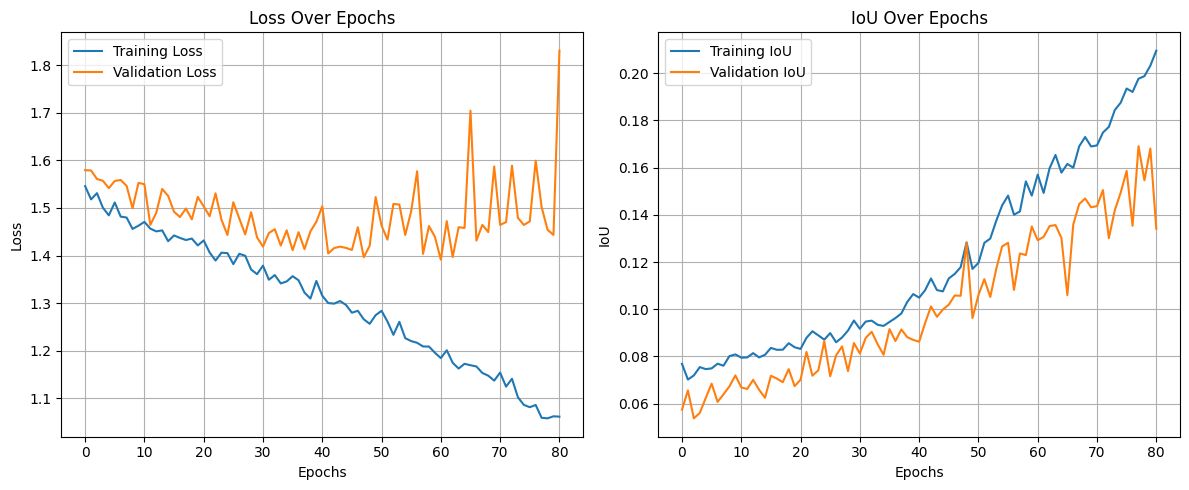

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Convert GPU tensors to CPU for plotting (to avoid errors)
train_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_loss']]
val_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_loss']]
train_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_metrics']]
val_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_metrics']]

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(train_metrics, label='Training IoU')
plt.plot(val_metrics, label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

At 140 epochs, the model seems to be approximately converging to the best possible performance with the chosen hyperparameters.